# Truss Displacement, Stress, and Reaction Force Assesment Program

This Python code provides a solution for the analysis of 2D truss structures using the direct stiffness method. The code calculates the displacements, reactions, and stresses of the truss elements.

## Dependencies
* NumPy
* Matplotlib

## Inputs
* Node coordinates (x, y)
* Boundary conditions for each node (horizontal constraint, vertical constraint)
* Roller angle (if applicable)
* Element connectivity (node indices for each element)
* Material and diameter of each element (Aluminium or Steel)
* External force magnitude, angle, and node number

## Outputs
* Displacements (dx, dy) at each node
* Reactions (Rx, Ry) at each boundary node
* Stress in each element
* Plot of the original and displaced truss structure


## Code Usage
* Install the necessary dependencies.
* Run the Python script.
* Follow the prompts to input node coordinates, boundary conditions, element connectivity, element properties, and external forces.
* View the printed results and the generated plots.

## Example
Suppose we have a truss structure with four nodes and five elements. The material properties, node coordinates, boundary conditions, element connectivity, and external forces are given. We run the Python script and input the required information when prompted. The script calculates the displacements, reactions, and stresses, and plots the original and displaced truss structures.

Enter the coordinates of node 0 (comma-separated): 0,0
Enter the Boundary Conditions of node 0 (comma-separated) (horizontal constraint, vertical contraint) 0 = Free, 1 = Fixed: 1,0
Enter the angle of the roller (degrees): 45
Enter the coordinates of node 1 (comma-separated): 0,10
Enter the Boundary Conditions of node 1 (comma-separated) (horizontal constraint, vertical contraint) 0 = Free, 1 = Fixed: 1,1
Enter the coordinates of node 2 (comma-separated): 12,6
Enter the Boundary Conditions of node 2 (comma-separated) (horizontal constraint, vertical contraint) 0 = Free, 1 = Fixed: 0,0
Enter the coordinates of node 3 (comma-separated): 12,0
Enter the Boundary Conditions of node 3 (comma-separated) (horizontal constraint, vertical contraint) 0 = Free, 1 = Fixed: 0,0
Enter the connectivity for element A (comma-separated node indices): 0,1
Enter the Material (A for Aluminium and S for Steel) for element A and Diameter of Rod (comma-separated node indices): S,0.5
Enter the connectivity for 

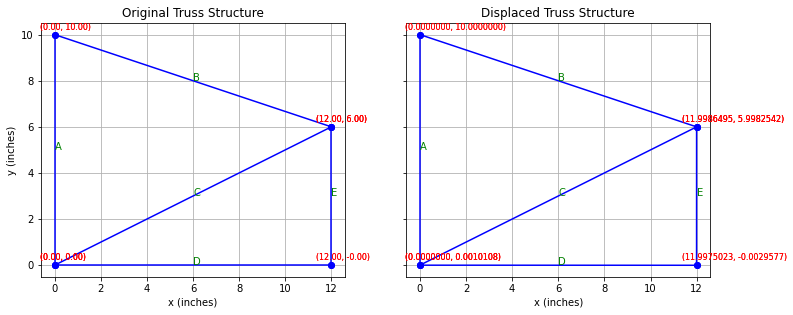

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt


# Constants
E_Steel = 30 * 10**6  # psi
E_Alum = 11 * 10**6   # psi

# Node coordinates
node_coordinates = []
boundaries = []
for i in range(4):
    coords = input(f"Enter the coordinates of node {i} (comma-separated): ")
    x, y = [float(value) for value in coords.split(',')]
    node_coordinates.append([x, y])
    bound = input(f"Enter the Boundary Conditions of node {i} (comma-separated) (horizontal constraint, vertical contraint) 0 = Free, 1 = Fixed: ")
    h,v = [int(value) for value in bound.split(',')]
    if (h == 1 and v == 0) or (h==0 and v == 1):
        roller_angle = float(input("Enter the angle of the roller (degrees): "))
    boundaries.append([int(i),int(h),int(v)])

nodes = np.array(node_coordinates)
Elements_Name = ['A','B','C','D','E']
# Element connectivity
element_connectivity = []
element_property = []
for i in Elements_Name:
    conn = input(f"Enter the connectivity for element {i} (comma-separated node indices): ")
    node1, node2 = [int(value) for value in conn.split(',')]
    element_connectivity.append([node1, node2])
    prop = input(f"Enter the Material (A for Aluminium and S for Steel) for element {i} and Diameter of Rod (comma-separated node indices): ")
    prop1, prop2 = [value for value in prop.split(',')]
    if prop1 == 'A':
        prop1 = E_Alum
    else:
            prop1 = E_Steel
    prop2 = ((float(prop2)/2)**2)*math.pi
    element_property.append([prop1,prop2])

elements = np.array(element_connectivity)


# Update boundary conditions based on the roller angle
boundary_conditions = np.array(boundaries)


# Material properties (element, E, A)
properties = np.array(element_property)
print(properties)
# External force (node, force_x, force_y)
forces = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [2, 0, 0],
    [3, 0, 0],
    
])

force_magnitude = float(input(f"Enter the Force Magnitude on Truss: ")) # arbitrary force magnitude, modify as needed
force_angle = float(input(f"Enter the Force Angle in Degrees (Counter-Clockwise from x-plane) on Truss: ")) # arbitrary force magnitude, modify as needed  # degrees
force_node = int(input(f"Enter the node number (0-3) the Force is applied on: "))
forces[force_node, 1] = force_magnitude * math.cos(math.radians(force_angle))
forces[force_node, 2] = force_magnitude * math.sin(math.radians(force_angle))


# Truss analysis function
def analyze_truss(nodes, elements, properties, forces, boundary_conditions):
    # Calculate number of nodes and elements
    num_nodes = nodes.shape[0]
    num_elements = elements.shape[0]

    # Calculate element lengths and unit vectors
    lengths = np.zeros(num_elements)
    unit_vectors = np.zeros((num_elements, 2))
    for i, element in enumerate(elements):
        node1 = nodes[element[0]]
        node2 = nodes[element[1]]
        dx = node2[0] - node1[0]
        dy = node2[1] - node1[1]
        length = np.sqrt(dx**2 + dy**2)
        unit_vectors[i] = [dx/length, dy/length]
        lengths[i] = length


    # Global stiffness matrix
    K = np.zeros((2*num_nodes, 2*num_nodes))
    for i, element in enumerate(elements):
        E, A = properties[i]
        length = lengths[i]
        unit_vector = unit_vectors[i]
        k = E*A/length

        # Local stiffness matrix
        k_local = np.array([
                    [1, 0, -1, 0],
                    [0, 1, 0, -1],
                    [-1, 0, 1, 0],
                    [0, -1, 0, 1]
        ]) * k
        # Local to global transformation matrix
        T = np.array([
            [unit_vector[0], 0, unit_vector[1], 0],
            [0, unit_vector[0], 0, unit_vector[1]],
            [unit_vector[1], 0, -unit_vector[0], 0],
            [0, unit_vector[1], 0, -unit_vector[0]]
        ])

        # Global stiffness matrix for element
        k_global = np.dot(T.T, np.dot(k_local, T))

        # Assemble global stiffness matrix
        for a in range(2):
            for b in range(2):
                K[2*element[a]:2*element[a]+2, 2*element[b]:2*element[b]+2] += k_global[a*2:a*2+2, b*2:b*2+2]
        
    # Apply boundary conditions
    for bc in boundary_conditions:
        node, constraint_x, constraint_y = bc
        if constraint_x:
            K[2*node, :] = 0
            K[:, 2*node] = 0
            K[2*node, 2*node] = 1
        if constraint_y:
            K[2*node+1, :] = 0
            K[:, 2*node+1] = 0
            K[2*node+1, 2*node+1] = 1
    
    # Solve for displacements
    F = np.zeros(2*num_nodes)
    for f in forces:
        node, force_x, force_y = f
        F[2*node] = force_x
        F[2*node+1] = force_y

    displacements = np.linalg.solve(K, F)

    # Calculate reactions
    reactions = np.zeros((boundary_conditions.shape[0], 2))
    for i, bc in enumerate(boundary_conditions):
        node, constraint_x, constraint_y = bc
        if constraint_x or constraint_y:
            reaction = np.dot(K[2*node:2*node+2, :], displacements)
            reactions[i] = reaction

    # Calculate stress in all elements
    stress = np.zeros(num_elements)
    for i, element in enumerate(elements):
        E, _ = properties[i]
        length = lengths[i]
        unit_vector = unit_vectors[i]
        displacement = displacements[2*element[0]:2*element[0]+2] - displacements[2*element[1]:2*element[1]+2]
        local_displacement = np.dot(unit_vector, displacement)
        stress[i] = E * local_displacement / length

    return displacements, reactions, stress

# Analyze truss and print results
displacements, reactions, stress = analyze_truss(nodes, elements, properties, forces, boundary_conditions)
print("\n|-----------Results-----------|")
print("\nDisplacements:")
for i, displacement in enumerate(displacements.reshape(-1, 2)):
    print(f"Node {i}: dx = {displacement[0]:.2e}, dy = {displacement[1]:.2e}")



print("\nReactions:")
for i, reaction in enumerate(reactions):
    print(f"Node {i}: Rx = {reaction[0]:.2e}, Ry = {reaction[1]:.2e}")

print("\nStress in elements:")
for i, stress_value in enumerate(stress):
    print(f"Element {i}: stress = {stress_value:.2e} psi")

  # Calculate the displaced nodes
displaced_nodes = nodes + displacements.reshape(-1, 2)

# Plot trusses in a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for i, element in enumerate(elements):
    node1, node2 = nodes[element[0]], nodes[element[1]]
    displaced_node1, displaced_node2 = displaced_nodes[element[0]], displaced_nodes[element[1]]
    
    # Plot truss in the first subplot
    ax1.plot([node1[0], node2[0]], [node1[1], node2[1]], 'bo-')
    ax1.annotate(f"({displaced_node1[0]:.2f}, {displaced_node1[1]:.2f})", (displaced_node1[0], displaced_node1[1]), textcoords="offset points", xytext=(-15, 5), fontsize=8, color='red')
    ax1.annotate(f"({displaced_node2[0]:.2f}, {displaced_node2[1]:.2f})", (displaced_node2[0], displaced_node2[1]), textcoords="offset points", xytext=(-15, 5), fontsize=8, color='red')
    ax1.annotate(f"{Elements_Name[i]}", (0.5 * (node1[0] + node2[0]), 0.5 * (node1[1] + node2[1])), fontsize=10, color='green')
    
    # Plot truss in the second subplot with displaced nodes
    ax2.plot([displaced_node1[0], displaced_node2[0]], [displaced_node1[1], displaced_node2[1]], 'bo-')
    ax2.annotate(f"({displaced_node1[0]:.7f}, {displaced_node1[1]:.7f})", (displaced_node1[0], displaced_node1[1]), textcoords="offset points", xytext=(-15, 5), fontsize=8, color='red')
    ax2.annotate(f"({displaced_node2[0]:.7f}, {displaced_node2[1]:.7f})", (displaced_node2[0], displaced_node2[1]), textcoords="offset points", xytext=(-15, 5), fontsize=8, color='red')
    ax2.annotate(f"{Elements_Name[i]}", (0.5 * (displaced_node1[0] + displaced_node2[0]), 0.5 * (displaced_node1[1] + displaced_node2[1])), fontsize=10, color='green')

ax1.set_aspect('equal', 'box')
ax1.set_title("Original Truss Structure")
ax1.set_xlabel('x (inches)')
ax1.set_ylabel('y (inches)')
ax1.grid(True)

ax2.set_aspect('equal', 'box')
ax2.set_title("Displaced Truss Structure")
ax2.set_xlabel('x (inches)')
ax2.grid(True)

plt.show()


ax2.set_aspect('equal', 'box')
ax2.set_title("Displaced Truss Structure")
ax2.set_xlabel('x (inches)')
ax2.grid(True)

plt.show()

